In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns=50

## 猜想:
房子在建造的時候可能會有某些特定的配置，像是越多的房間也有較高的機會搭配越多的衛浴設備，甚至可以進行聚類，例如:二房一衛、四房兩衛等等的配置。然而這些配置也會影響房價，像是四房比二房貴的機率比較高。最終可以從潛變量空間中約略預測房價。那麼在類別變項中或許也有這樣的組合，並且對於房價有預測能力。
## 理論:
若一群資料點在高維度空間中有某種分布，且該分布可以用較低的維度表達，則可以訓練VAE將資料點投影進低維度空間，再從低維度空間重建輸入資料。
換句話說，可以透過VAE建立能夠儲存資訊的低維度空間，且給定一個位於該低維空間中的點可以反推其在高維度空間中的位置。
## 假設:
若房屋的類別變項具備某種特定分布，應該可以輸入至VAE在重建回來，同時在潛變量空間中存在有意義的分布，或許跟房價有某種程度上應對關係。
## 模型意義:
這是一個非監督式學習。因為不需要用到答案(這裡是SalePrice)，所以可以把訓練跟測試資料都拿來使用，不浪費測試資料，也比較不須擔心對SalePrice的過度擬合。若可以在潛變量空間上看出房價的分布，基本上可以確定類別變項對房價是有影響的，畢竟訓練過程模型沒有對房價進行推論，不可能從中學到關於房價的任何資訊。

In [2]:
train = pd.read_csv('train.csv',index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')

In [3]:
print(train.columns.difference(test.columns))
print(test.columns.difference(train.columns))
#確定除了label SalePrice之外訓練和測試資料的欄位是一樣的

Index(['SalePrice'], dtype='object')
Index([], dtype='object')


In [4]:
#取得訓練資料的房價
price = train['SalePrice']
#合併訓練和測試資料
data = train.append(test)
#拿掉SalePrice，以免造成data leakage
data = data.drop('SalePrice',axis=1)
#因為針對類別變項，所以只選取object data ttype
data = data.select_dtypes('object')
#把所有類別變項欄位進行one-hot-encoding，na值不增加na欄位，而是全部填0，同時也比較能因應未來若有新資料的問題(某欄位有新的NAN)
data = pd.get_dummies(data)

In [5]:
#未來新資料輸入的欄位要按照這個順序，若有欄位不存在則fillna(0)，若有新的欄位則會被捨棄
print(data.columns)
print(data.columns.size)

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave',
       'LotShape_IR1',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=252)
252


# VAE Reference:
    https://www.itread01.com/content/1546536080.html

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp

In [7]:
def KLDivergence_NormalDistribution(mean,log_var):
    #原文的損失函數，計算某高斯分布(mean,log_variance)與標準高斯分布N(0,1)的KLdivergence
    #公式推導參考以上文章
    var = tf.math.exp(log_var)
    #各計算分量的KLDivergence
    loss = (-log_var + mean**2 + var - 1)/2
    #由於各分量獨立，最後再將KLDivergence總和起來就好
    loss = tf.math.reduce_sum(loss,axis=-1)
    #計算整個batch的平均loss
    loss = tf.math.reduce_mean(loss)
    return loss

def Resample_Distance(mean,log_var,sample):
    #參考:https://www.tensorflow.org/tutorials/generative/cvae
    #若sample由某個高斯分布取出(mean,log_variance)，且該分布要與標準高斯分布看齊，
    #換句話說該sample從該分布抽出的機率與從標準高斯分布的機率應該要相似(KLdivergence相近)
    def gaussian_log_prob(mean,log_var,sample):
        #計算某點從多變量且各變量獨立的高斯分布取樣的機率對數值，因為變量獨立，使用MultivariateNormalDiag
        var = tf.math.exp(log_var)
        std = tf.math.sqrt(var)
        log_prob = tfp.distributions.MultivariateNormalDiag(mean,std).log_prob(sample)
        return log_prob
    log_prob_from_dist = gaussian_log_prob(mean, log_var, sample)
    log_prob_from_norm = gaussian_log_prob(tf.zeros_like(mean), tf.zeros_like(mean), sample)
    #計算機率的差異
    loss = log_prob_from_dist - log_prob_from_norm
    #計算整個batch的平均loss
    loss = tf.math.reduce_mean(loss)
    return loss

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,body,latent_dim):
        super().__init__()
        self.body = body
        self.last_layer = tf.keras.layers.Dense(latent_dim*2)
    
    def call(self,x):
        x = self.body(x)
        #z_dist.shape (batch_size, latent_dim*2[z_mean, z_log_var])
        #latent space的mean和log_var同時預測，並且再拆開
        z_dist = self.last_layer(x)
        z_mean, z_log_var = tf.split(z_dist,2,axis=-1)
        return z_mean, z_log_var
    
    def predict(self,x):
        #預測只回傳分布中心位置
        z_mean, z_log_var = self(x)
        return z_mean
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self,body):
        super().__init__()
        self.body = body
        self.last_layer = tf.keras.layers.Dense(252,activation='sigmoid') #252是要重建的欄數
        
    def call(self,z):
        z = self.body(z)
        x_reconstruct = self.last_layer(z)
        return x_reconstruct
    
    
class Model(tf.keras.Model):
    def __init__(self,encoder_body,decoder_body,latent_dim,distribution_regularization_rate=0.002):
        super().__init__()
        self.encoder = Encoder(encoder_body,latent_dim)
        self.decoder = Decoder(decoder_body)
        self.distribution_regularization_rate = distribution_regularization_rate
        
    def call(self,x):
        x = tf.cast(x, tf.float64)
        #encoder將資料投影至latent space
        z_mean, z_log_var = self.encoder(x)
        #從latent space的分布中取樣
        z_resample = self.resample(z_mean, z_log_var)
        #利用取樣點重建輸入資料
        x_reconstruct = self.decoder(z_resample)
        return x_reconstruct, z_mean, z_log_var, z_resample
        
    def resample(self, z_mean, z_log_var):
        #z_mean.shape: (batch_size,latent_dim)
        #z_log_var.shape: (batch_size,latent_dim)
        #encoder將資料轉化為在latent space(較低維度空間)上的高斯分布，參數為分布中心(z_mean),變異數自然對數(z_log_var)，
        #且z_log_var需轉換成公式需要的標準差(z_std)
        z_var = tf.math.exp(z_log_var)
        z_std = tf.math.sqrt(z_var)
        z_resample = tfp.distributions.MultivariateNormalDiag(z_mean,z_std).sample()
        #在給定的高斯分布(z_mean,z_std)重新取樣，且取樣的過程可導
        #z_resample.shape: (batch_size,latent_dim)
        return z_resample
    
    def encode(self,x):
        return self.encoder(x)[0]
    
    def decode(self,z):
        return self.decoder(z)
        
    def compile(self,latent_loss,optimizer):
        super().compile()
        self.optimizer = optimizer
        
        self.latent_distribution_loss = latent_loss
        self.reconstruction_loss = tf.keras.losses.BinaryCrossentropy()
        
        self.latent_distribution_loss_metric = tf.keras.metrics.Mean(name='latent_dist')
        self.reconstruction_loss_metric = tf.keras.metrics.Mean(name='reconstruct')
        self.total_loss_metric = tf.keras.metrics.Mean(name='total')
    
    @property
    def metrics(self):
        return [self.latent_distribution_loss_metric,
                self.reconstruction_loss_metric,
                self.total_loss_metric]
    
    def compute_loss(self, x, x_reconstruct, z_mean, z_log_var, z_resample):
        if self.latent_distribution_loss is KLDivergence_NormalDistribution:
            latent_distribution_loss = self.latent_distribution_loss(z_mean,z_log_var)
        else:
            latent_distribution_loss = self.latent_distribution_loss(z_mean,z_log_var,z_resample)
        
        reconstruction_loss = self.reconstruction_loss(x, x_reconstruct)
        return latent_distribution_loss, reconstruction_loss
    
    def train_step(self,x):
        with tf.GradientTape() as tape:
            x_reconstruct, z_mean, z_log_var, z_resample = self(x)
            latent_distribution_loss, reconstruction_loss  = self.compute_loss(x, x_reconstruct, z_mean, z_log_var, z_resample)
            total_loss = self.distribution_regularization_rate * latent_distribution_loss + reconstruction_loss
            
        self.latent_distribution_loss_metric.update_state(latent_distribution_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.total_loss_metric.update_state(total_loss)
        
        gradients = tape.gradient(total_loss,self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {m.name:m.result() for m in self.metrics}

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(data).batch(32)

In [17]:
def run(loss, distribution_regularization_rate, run_times=10, epochs_each_time=10,seed=101):
    tf.random.set_seed(seed)
    encoder = tf.keras.Sequential([tf.keras.layers.Dense(200,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(50,activation='relu'),
                               tf.keras.layers.Dense(20,activation='relu')])
    decoder = tf.keras.Sequential([tf.keras.layers.Dense(20,activation='relu'),
                               tf.keras.layers.Dense(50,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(200,activation='relu')])
    model = Model(encoder,decoder,2,distribution_regularization_rate)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss,optimizer)
    for i in range(run_times):
        model.fit(train_ds,epochs=epochs_each_time)
        z = model.encode(data.loc[train.index].values)
        plot = plt.scatter(x = z[:,0],y=z[:,1],c=np.log(price.values),cmap='rainbow',s=2)
        plt.title(f'run times: {i+1} ({epochs_each_time} epochs each time)')
        plt.colorbar(plot)
        plt.show()

Epoch 1/3
92/92 [==============================] - 2s 7ms/step - latent_dist: 4.3717 - reconstruct: 0.2857 - total: 0.2988
Epoch 2/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 0.6527 - reconstruct: 0.1979 - total: 0.1999
Epoch 3/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.2270 - reconstruct: 0.1794 - total: 0.1831


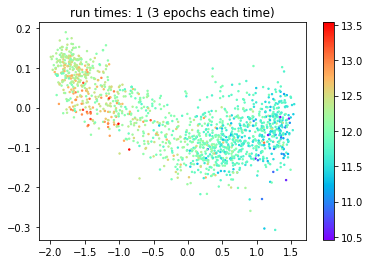

Epoch 1/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.5037 - reconstruct: 0.1699 - total: 0.1744
Epoch 2/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.6799 - reconstruct: 0.1657 - total: 0.1707
Epoch 3/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.7713 - reconstruct: 0.1623 - total: 0.1676


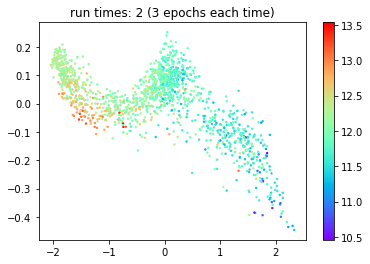

Epoch 1/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.7957 - reconstruct: 0.1617 - total: 0.1671
Epoch 2/3
92/92 [==============================] - 1s 6ms/step - latent_dist: 1.7718 - reconstruct: 0.1600 - total: 0.1653
Epoch 3/3
92/92 [==============================] - 1s 7ms/step - latent_dist: 1.8349 - reconstruct: 0.1597 - total: 0.1652


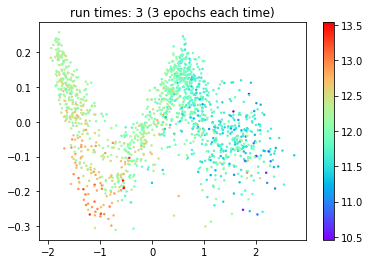

In [18]:
run(KLDivergence_NormalDistribution, 0.003, 3, 3)

Epoch 1/3
92/92 [==============================] - 3s 9ms/step - latent_dist: 4.4794 - reconstruct: 0.2835 - total: 0.2970
Epoch 2/3
92/92 [==============================] - 1s 9ms/step - latent_dist: 0.5454 - reconstruct: 0.1973 - total: 0.1989
Epoch 3/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.3336 - reconstruct: 0.1773 - total: 0.1813


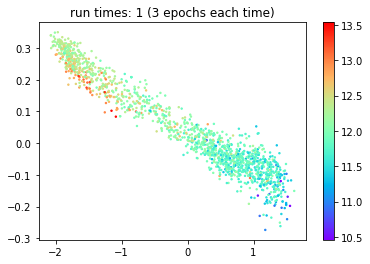

Epoch 1/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.5008 - reconstruct: 0.1696 - total: 0.1741
Epoch 2/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.6540 - reconstruct: 0.1661 - total: 0.1711
Epoch 3/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.7476 - reconstruct: 0.1632 - total: 0.1684


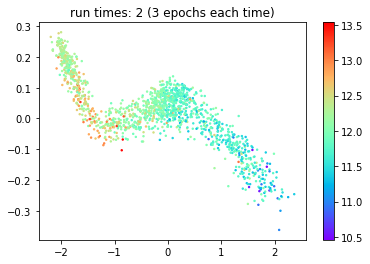

Epoch 1/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.7894 - reconstruct: 0.1619 - total: 0.1672
Epoch 2/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.8043 - reconstruct: 0.1602 - total: 0.1656
Epoch 3/3
92/92 [==============================] - 1s 8ms/step - latent_dist: 1.8445 - reconstruct: 0.1597 - total: 0.1652


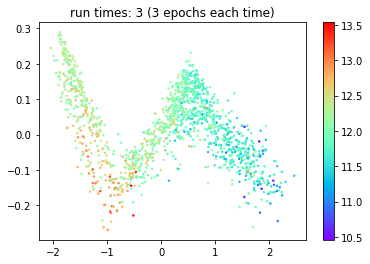

In [19]:
run(Resample_Distance, 0.003, 3, 3)